In [1]:
from bs4 import BeautifulSoup
import csv
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
import time
import pandas as pd
import numpy as np
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium import webdriver

In [34]:
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import time
import csv
import pandas as pd
from selenium import webdriver

urls = [
    "https://www.tokopedia.com/mykonos/mykonos-bonfire-vanilla-extrait-de-parfum?extParam=src%3Dshop%26whid%3D6274994",
    "https://www.tokopedia.com/mykonos/mykonos-aphrodite-eau-de-parfume-50ml-100ml-50-ml-16e3a?extParam=src%3Dshop%26whid%3D6274994",
    "https://www.tokopedia.com/mykonos/mykonos-x-niky-cu-california-edp-100ml?extParam=src%3Dshop%26whid%3D6274994",
    "https://www.tokopedia.com/hmnsperfume/hmns-perfume-orgasm-100ml-limited-edition?extParam=ivf%3Dfalse?extParam=whid%3D6651138",
    "https://www.tokopedia.com/hmnsperfume/hmns-perfume-the-perfection-100ml?extParam=ivf%3Dfalse?extParam=whid%3D6651138",
    "https://www.tokopedia.com/hmnsperfume/hmns-perfume-essence-of-the-sun-eos-100ml?extParam=ivf%3Dfalse?extParam=whid%3D6651138",
    "https://www.tokopedia.com/saffnco/saff-co-extrait-de-parfum-s-o-t-b?extParam=src%3Dshop%26whid%3D8882951",
    "https://www.tokopedia.com/saffnco/saff-co-extrait-de-parfum-loui?extParam=whid%3D8882951%26src%3Dshop",
    "https://www.tokopedia.com/saffnco/saff-co-extrait-de-parfum-saff?extParam=src%3Dshop%26whid%3D8882951"
]

service = Service('chromedriver.exe')
driver = webdriver.Chrome(service=service)

def scrape_product(url):
    driver.get(url)
    time.sleep(3)
    scroll_page(1000)
    content = driver.page_source
    BS = BeautifulSoup(content, 'html.parser')

    nama_produk = BS.find("h1", {"data-testid": "lblPDPDetailProductName"})
    nama_produk = nama_produk.text.strip() if nama_produk else "Nama produk tidak ditemukan"

    deskripsi_produk = BS.find("div", {"data-testid": "lblPDPDescriptionProduk"})
    deskripsi_produk = deskripsi_produk.get_text(" ", strip=True) if deskripsi_produk else "Deskripsi produk tidak ditemukan"

    rating_section = BS.find("div", class_="css-p20wo7")
    if rating_section:
        rating = rating_section.find("span", class_="css-tzru2z")
        max_rating = rating_section.find("span", class_="css-1desc18")
        rating_value = rating.text.strip() if rating else "Rating tidak ditemukan"
        max_rating_value = max_rating.text.strip('/') if max_rating else "Nilai maksimal tidak ditemukan"
    else:
        rating_value = max_rating_value = "Rating tidak ditemukan"
    
    stars_section = BS.find("div", class_= 'css-10emkyv')
    if stars_section:
        bintang5 = stars_section.find("span", class_ = "css-obfebs")
        bintang5_value = bintang5.text.strip('()') if rating else "Rating tidak ditemukan"

    return {
        "url": url,
        "nama_produk": nama_produk,
        "deskripsi_produk": deskripsi_produk,
        "rating": rating_value,
        "max_rating": max_rating_value,
        "bintang5": bintang5_value
    }

def expand_reviews():
    try:
        more_buttons = driver.find_elements(By.CSS_SELECTOR, "button.css-89c2tx")
        for button in more_buttons:
            driver.execute_script("arguments[0].click();", button)
            time.sleep(1)
    except Exception as e:
        print("Error menekan tombol Selengkapnya:", e)

def get_reviews():
    reviews = driver.find_elements(By.CSS_SELECTOR, "article[class*=css-72zbc4]")
    data = []

    for idx, review in enumerate(reviews):
        try:
            # Ambil konten review
            content_element = review.find_element(By.CSS_SELECTOR, "span[data-testid='lblItemUlasan']")
            content = content_element.text.strip()

            # Ambil rating bintang
            stars = review.find_elements(By.CSS_SELECTOR, "svg.unf-icon")
            filled_stars = 0
            for star_idx, star in enumerate(stars):
                fill_color = star.get_attribute("fill")
                print(f"Bintang {star_idx+1}: {fill_color}")
                if "#FFC400" in fill_color:
                    filled_stars += 1

            data.append({"content": content, "rating": filled_stars})
        except Exception as e:
            print(f"Error mengambil review di indeks {idx}:", e)
    return data


def go_to_next_page():
    try:
        next_button = WebDriverWait(driver, 5).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, "button[aria-label='Laman berikutnya']"))
        )
        if next_button.get_attribute("disabled") is not None:
            print("Tombol 'Laman berikutnya' dinonaktifkan. Sudah di halaman terakhir.")
            return False
        driver.execute_script("arguments[0].click();", next_button)
        time.sleep(3)
        return True
    except Exception as e:
        print("Tidak ada tombol 'Laman berikutnya':", e)
        return False

def scroll_page(pixels):
    """
    Scroll the page vertically by the specified number of pixels.
    """
    driver.execute_script(f"window.scrollBy(0, {pixels});")
    time.sleep(1)

def scrape_reviews(product_url):
    review_url = f"{product_url}/review"
    driver.get(review_url)
    time.sleep(3)
    scroll_page(1000)

    all_reviews = []

    while True:
        expand_reviews()
        reviews = get_reviews()
        all_reviews.extend(reviews)

        if not go_to_next_page():
            break

    return all_reviews

for url in urls:
    product_data = scrape_product(url)
    nama_file_produk = product_data["nama_produk"].replace(" ", "_").lower() + "_info.csv"
    df_produk = pd.DataFrame([product_data])
    df_produk.to_csv(nama_file_produk, index=False, encoding="utf-8")
    print(f"Informasi produk disimpan di {nama_file_produk}")

driver.quit()


Informasi produk disimpan di mykonos_bonfire_vanilla_extrait_de_parfum_info.csv
Informasi produk disimpan di mykonos_aphrodite_eau_de_parfume_50ml_&_100ml_-_50_ml_info.csv
Informasi produk disimpan di mykonos_x_niky_cu_california_edp_100ml_info.csv
Informasi produk disimpan di hmns_perfume_-_orgasm_100ml_limited_edition_info.csv
Informasi produk disimpan di hmns_perfume_-_the_perfection_100ml_info.csv
Informasi produk disimpan di hmns_perfume_-_essence_of_the_sun_eos_100ml_info.csv
Informasi produk disimpan di saff_&_co._extrait_de_parfum_-_s.o.t.b_info.csv
Informasi produk disimpan di saff_&_co._extrait_de_parfum_-_loui_info.csv
Informasi produk disimpan di saff_&_co._extrait_de_parfum_-_saff_info.csv


In [67]:
import re
import string
from nltk.tokenize import word_tokenize
import emoji
import pandas as pd
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
lemmatizer = factory.create_stemmer()

def replace_emojis(text):
    text = emoji.demojize(text)

    text = re.sub(r"[_-]", "", text)

    text = text.replace(":", " ")

    text = re.sub(r"\s+", " ", text).strip()

    return text

def remove_repeated_characters(text):
    return re.sub(r'(.)\1{2,}', r'\1', text)

def preprocess_review(text):
    text = text.lower()

    text = replace_emojis(text)

    text = re.sub(r"\.\.\.|…", " ", text)

    text = text.replace(",", " ")
    text = text.replace("’", "") 

    text = text.translate(str.maketrans("", "", string.punctuation))

    text = re.sub(r"\d+", "", text)

    text = remove_repeated_characters(text)

    text = re.sub(r"\b\w*nya\b", "", text)

    tokens = word_tokenize(text)

    lemmatized_tokens = [lemmatizer.stem(token) for token in tokens]

    return ' '.join(lemmatized_tokens)


def process_csv(file_path, output_path):

    df = pd.read_csv(file_path)

    if 'content' not in df.columns:
        raise ValueError("Kolom 'content' tidak ditemukan dalam file CSV")

    df['processed_review'] = df['content'].apply(preprocess_review)

    df.to_csv(output_path, index=False)

# Contoh penggunaan untuk beberapa file CSV
file_paths = [
    "hmns_perfume_-_essence_of_the_sun_eos_100ml_reviews.csv",
    "hmns_perfume_-_orgasm_100ml_limited_edition_reviews.csv",
    "hmns_perfume_-_the_perfection_100ml_reviews.csv",
    "mykonos_aphrodite_eau_de_parfume_50ml_&_100ml_-_50_ml_reviews.csv",
    "mykonos_bonfire_vanilla_extrait_de_parfum_reviews.csv",
    "mykonos_x_niky_cu_california_edp_100ml_reviews.csv",
    "saff_&_co._extrait_de_parfum_-_loui_reviews.csv",
    "saff_&_co._extrait_de_parfum_-_s.o.t.b_reviews.csv",
    "saff_&_co._extrait_de_parfum_-_saff_reviews.csv",
    "merged_reviews.csv"
]
output_paths = [
    "eos.csv",
    "orgasm.csv",
    "perfection.csv",
    "aphrodite.csv",
    "bonfire.csv",
    "california.csv",
    "loui.csv",
    "sotb.csv",
    "saff.csv",
    "merge_clean.csv"
]

for input_path, output_path in zip(file_paths, output_paths):
    process_csv(input_path, output_path)
    print(f"File {input_path} berhasil diproses dan disimpan ke {output_path}")


File hmns_perfume_-_essence_of_the_sun_eos_100ml_reviews.csv berhasil diproses dan disimpan ke eos.csv
File hmns_perfume_-_orgasm_100ml_limited_edition_reviews.csv berhasil diproses dan disimpan ke orgasm.csv
File hmns_perfume_-_the_perfection_100ml_reviews.csv berhasil diproses dan disimpan ke perfection.csv
File mykonos_aphrodite_eau_de_parfume_50ml_&_100ml_-_50_ml_reviews.csv berhasil diproses dan disimpan ke aphrodite.csv
File mykonos_bonfire_vanilla_extrait_de_parfum_reviews.csv berhasil diproses dan disimpan ke bonfire.csv
File mykonos_x_niky_cu_california_edp_100ml_reviews.csv berhasil diproses dan disimpan ke california.csv
File saff_&_co._extrait_de_parfum_-_loui_reviews.csv berhasil diproses dan disimpan ke loui.csv
File saff_&_co._extrait_de_parfum_-_s.o.t.b_reviews.csv berhasil diproses dan disimpan ke sotb.csv
File saff_&_co._extrait_de_parfum_-_saff_reviews.csv berhasil diproses dan disimpan ke saff.csv
File merged_reviews.csv berhasil diproses dan disimpan ke merge_clean

# HMNS

In [50]:
eos = pd.read_csv("hmns_perfume_-_essence_of_the_sun_eos_100ml_info.csv")
orgasm = pd.read_csv("hmns_perfume_-_orgasm_100ml_limited_edition_info.csv")
perfection = pd.read_csv("hmns_perfume_-_the_perfection_100ml_info.csv")

In [120]:
import pandas as pd

file_path = 'eos.csv'
data = pd.read_csv(file_path)

data.head(), data.columns

(                                             content  rating  \
 0  repurchase karena memang seenak itu wanginya, ...       5   
 1  sempet panik, gue kira parfumenya bocor (foto ...       5   
 2  wishlist beberapa bulan lalu akhirnya kebeli j...       5   
 3  Wah…ini sih emang gak boong ternyata review2 d...       5   
 4  wanginya lumayan awet yah untuk aktivitas dala...       5   
 
                                     processed_review  
 0  repurchase seenak warm floral manis enak bange...  
 1  sempet panik bocor foto kena sesuai harapkan s...  
 2  wishlist kebeli kemaren nahan karna parfume en...  
 3  emang boong review youtube emang beneran enak ...  
 4  lumayan awet aktivitas ruangan kerasa tipistip...  ,
 Index(['content', 'rating', 'processed_review'], dtype='object'))

In [49]:
eos[["rating","bintang5"]]

,rating,bintang5
0,4.9,8200


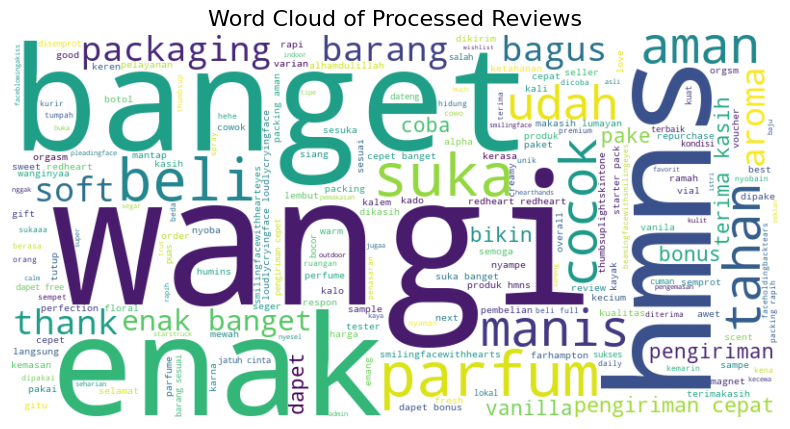

In [121]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = " ".join(review for review in data['processed_review'].dropna())

wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Processed Reviews", fontsize=16)
plt.show()

In [122]:
import pandas as pd

file_path = 'orgasm.csv'
data = pd.read_csv(file_path)

data.head(), data.columns

(                                             content  rating  \
 0  awalnya pas di spray ada wangi segernya gt, la...       5   
 1  Wanginya enak, kalem, bikin tenang, cocok buat...       5   
 2  Akhirnya sampai juga, tidak ada cacat pada bra...       5   
 3  akhirnya kesampaian juga punya orgsm. senang b...       5   
 4  akhirnya kebeli juga parfume ini, udah pengen ...       5   
 
                                     processed_review  
 0  spray wangi sweet bikin enek sweet feminine ke...  
 1      enak kalem bikin tenang cocok orang tipe calm  
 2                            cacat brang partypopper  
 3  orgsm senang banget aman kalengkaleng enak sem...  
 4  kebeli parfume udah pengen wangi banget manis ...  ,
 Index(['content', 'rating', 'processed_review'], dtype='object'))

In [51]:
orgasm[["rating","bintang5"]]

,rating,bintang5
0,4.9,19664


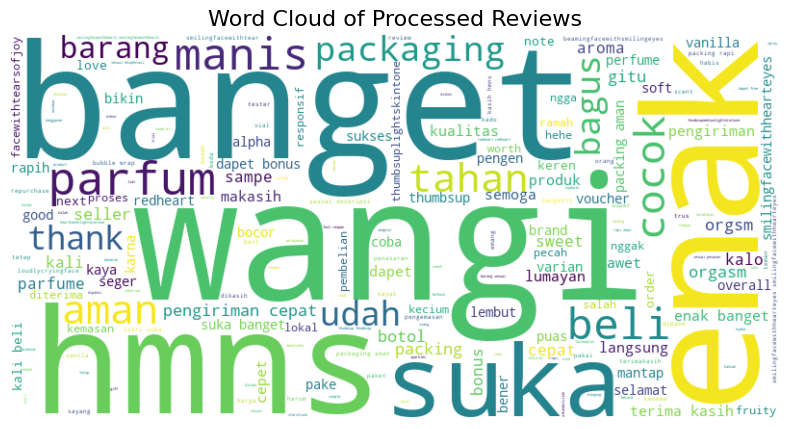

In [123]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all processed reviews into a single string
text = " ".join(review for review in data['processed_review'].dropna())

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Processed Reviews", fontsize=16)
plt.show()

In [125]:
import pandas as pd

# Load the uploaded file to check its structure
file_path = 'perferction.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe to understand its structure
data.head(), data.columns

(                                             content  rating  \
 0  Sudah repurchase botol ketiga, suka banget sm ...       5   
 1  Barang sesuai. Kiriman cepat. First time beli ...       5   
 2  Barang oke. Pengiriman cepat. Bahan dan Wangi ...       5   
 3  ❗️HONEST REVIEW 1. Packaging Premium 🎁: Dari b...       5   
 4  paket sampai dengan aman. udah dapat referensi...       5   
 
                                     processed_review  
 0  repurchase botol ketiga suka banget dapet vouc...  
 1  barang sesuai kiriman cepat first time beli ke...  
 2   barang pengiriman cepat bahan wangi terima kasih  
 3  redexclamationmark honest review packaging pre...  
 4  paket aman udah referensi kiri kanan parfum di...  ,
 Index(['content', 'rating', 'processed_review'], dtype='object'))

In [52]:
perfection[["rating","bintang5"]]

,rating,bintang5
0,4.9,11977


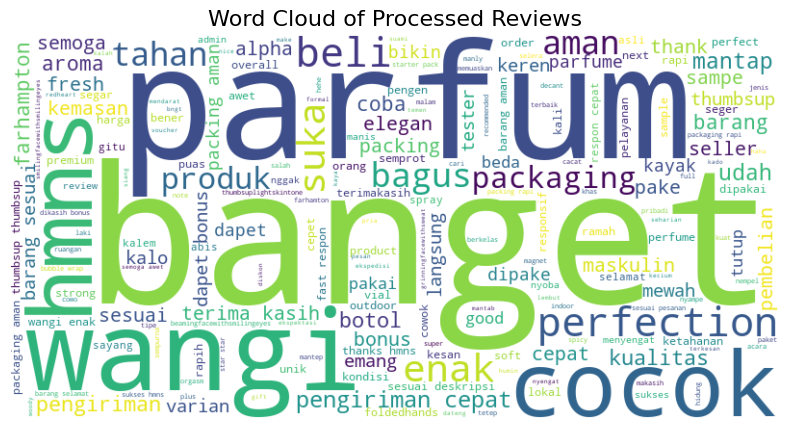

In [126]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all processed reviews into a single string
text = " ".join(review for review in data['processed_review'].dropna())

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Processed Reviews", fontsize=16)
plt.show()

# Mykonos

In [45]:
aphordite = pd.read_csv("mykonos_aphrodite_eau_de_parfume_50ml_&_100ml_-_50_ml_info.csv")
bonfire = pd.read_csv("mykonos_bonfire_vanilla_extrait_de_parfum_info.csv")
california = pd.read_csv("mykonos_x_niky_cu_california_edp_100ml_info.csv")

In [128]:
import pandas as pd

# Load the uploaded file to check its structure
file_path = 'aphrodite.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe to understand its structure
data.head(), data.columns

(                                             content  rating  \
 0  waw.. Amaze bangett .. di keterangannya PO 30 ...       5   
 1  Suka banget sama wanginya, dapat bonus vanili ...       5   
 2  pengemasan bagus berlapis2 buble wrap, harum b...       5   
 3  Beli krn suka desain botolnya yg lucu. Pertama...       5   
 4  Wanginya kyk ada bau2 tembakau nya campur wang...       5   
 
                                     processed_review  
 0  amaze bangett udah sangka kayak parfum mahal b...  
 1  suka banget bonus vanili cloud soft mykonos ja...  
 2  pengemasan bagus berlapis buble wrap harum dib...  
 3  beli suka desain lucu beli coba aphrodite semp...  
 4  tembakau campur wangi manis biskuit plastikin ...  ,
 Index(['content', 'rating', 'processed_review'], dtype='object'))

In [46]:
aphordite[["rating","bintang5"]]

,rating,bintang5
0,4.9,604


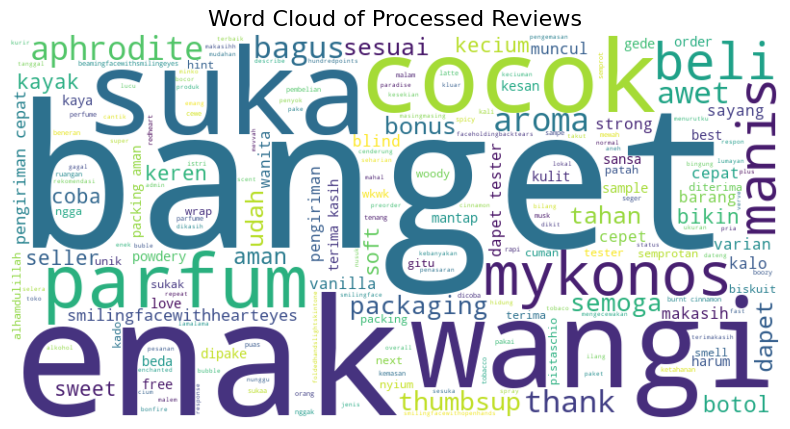

In [129]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all processed reviews into a single string
text = " ".join(review for review in data['processed_review'].dropna())

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Processed Reviews", fontsize=16)
plt.show()

In [131]:
import pandas as pd

# Load the uploaded file to check its structure
file_path = 'bonfire.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe to understand its structure
data.head(), data.columns

(                                             content  rating  \
 0  wah gila wanginya keren banget, awal nyium kek...       5   
 1  Pengirimannya cepat, respon penjual juga cepat...       5   
 2  harum kaya marshmallow manis , dapet botol kec...       5   
 3  Trust me,this smell exactly like v&k sp1cebomb...       5   
 4  kualitas g diragukan, wanginya di aku pertama ...       5   
 
                                     processed_review  
 0  gila keren banget nyium maskulin banget udah d...  
 1  cepat respon penjual cepat terbaik semangat su...  
 2  harum kaya marshmallow manis dapet botol pengi...  
 3  trust this smell exactly like spcebomb with sm...  
 4  kualitas diragukan kali semprot tajam banget s...  ,
 Index(['content', 'rating', 'processed_review'], dtype='object'))

In [47]:
bonfire[["rating","bintang5"]]

,rating,bintang5
0,4.9,862


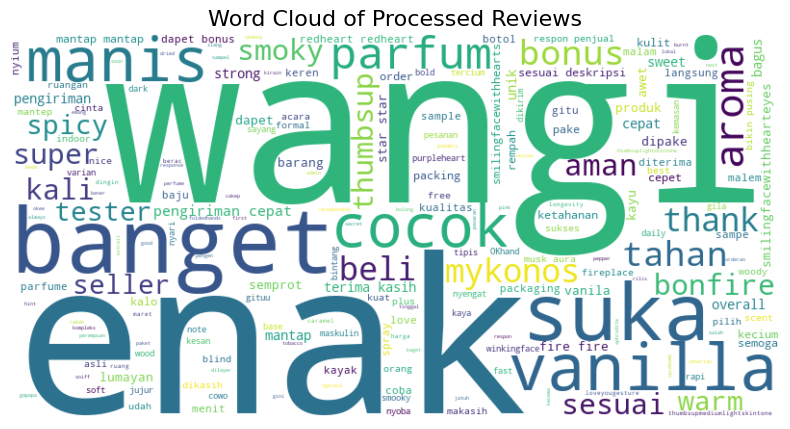

In [132]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all processed reviews into a single string
text = " ".join(review for review in data['processed_review'].dropna())

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Processed Reviews", fontsize=16)
plt.show()

In [134]:
import pandas as pd

# Load the uploaded file to check its structure
file_path = 'california.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe to understand its structure
data.head(), data.columns

(                                             content  rating  \
 0  Wanginya berkelas, dipakai outdoor cocok sekal...       5   
 1  paket sampai dengan aman sesuai deskripsi teri...       5   
 2  Pengiriman termasuk cepat. Admin juga mengusah...       5   
 3  packing an sangat aman bubble wrap 5 lapis kur...       5   
 4  Pengiriman 2 hari, packaging paketnya bagus. A...       5   
 
                                     processed_review  
 0  berkelas dipakai outdoor cocok sabarsabar menu...  
 1       paket aman sesuai deskripsi terimakasih yaaa  
 2  pengiriman cepat admin mengusahakan dikirim ad...  
 3  packing aman bubble wrap lapis kasih plastik p...  
 4  pengiriman packaging bagus abis dipake bbrp up...  ,
 Index(['content', 'rating', 'processed_review'], dtype='object'))

In [48]:
california[["rating","bintang5"]]

,rating,bintang5
0,5.0,725


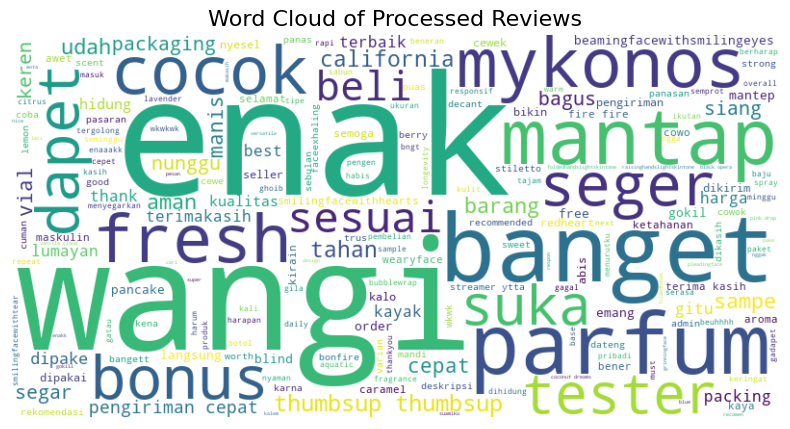

In [135]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all processed reviews into a single string
text = " ".join(review for review in data['processed_review'].dropna())

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Processed Reviews", fontsize=16)
plt.show()

# saff & co

In [42]:
loui = pd.read_csv("saff_&_co._extrait_de_parfum_-_loui_info.csv")
sotb = pd.read_csv("saff_&_co._extrait_de_parfum_-_s.o.t.b_info.csv")
saff = pd.read_csv("saff_&_co._extrait_de_parfum_-_saff_info.csv")

In [138]:
import pandas as pd

# Load the uploaded file to check its structure
file_path = 'loui.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe to understand its structure
data.head(), data.columns

(                                             content  rating  \
 0  Wangi paling cocok buat aku Segernya Soft dan ...       5   
 1  wanginya enak sweet gitu, tahan lama juga cuma...       5   
 2  kemasan luar agak penyok tapi terlindung bagia...       4   
 3  Wanginya sesuai selera saya, lembut, mirip Bul...       5   
 4  aroma seger mawarnya enak banget cocok dipakai...       5   
 
                                     processed_review  
 0  wangi cocok soft awet banget seharian dapet te...  
 1  enak sweet gitu tahan cuman kecium aman suka w...  
 2  kemasan penyok terlindung mantap packing aman ...  
 3  sesuai selera lembut bulgari jasmine kuat seha...  
 4  aroma seger enak banget cocok dipakai daily ng...  ,
 Index(['content', 'rating', 'processed_review'], dtype='object'))

In [41]:
loui[["rating","bintang5"]]

,rating,bintang5
0,4.9,4512


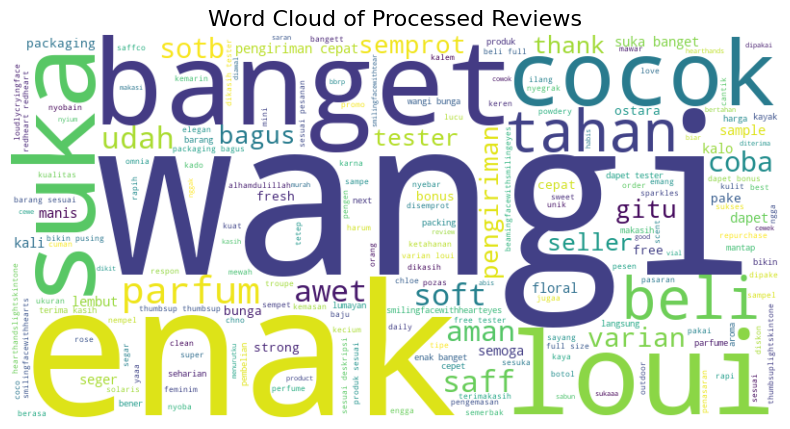

In [139]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all processed reviews into a single string
text = " ".join(review for review in data['processed_review'].dropna())

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Processed Reviews", fontsize=16)
plt.show()

In [140]:
import pandas as pd

# Load the uploaded file to check its structure
file_path = 'sotb.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe to understand its structure
data.head(), data.columns

(                                             content  rating  \
 0  barang dikirim sesuai pesanan dan deskripsi. r...       5   
 1  Dus paket udah kayak pesen promo Geprek dari S...       4   
 2  Produk ini luar biasa! Desainnya modern dan pr...       5   
 3  Awalnya coba ini yg versi mininya, ehh naksir ...       5   
 4  tahan lama poll sotb bukan kaleng kaleng,bonus...       5   
 
                                     processed_review  
 0  barang dikirim sesuai pesanan deskripsi respon...  
 1  paket udah kayak pesen promo geprek saff partu...  
 2  produk modern praktis cocok penggunaan seharih...  
 3  coba versi naksir suka feminim sekaliii free w...  
 4  tahan poll sotb kaleng kaleng bonus parfum ill...  ,
 Index(['content', 'rating', 'processed_review'], dtype='object'))

In [43]:
sotb[["rating","bintang5"]]

,rating,bintang5
0,5.0,8833


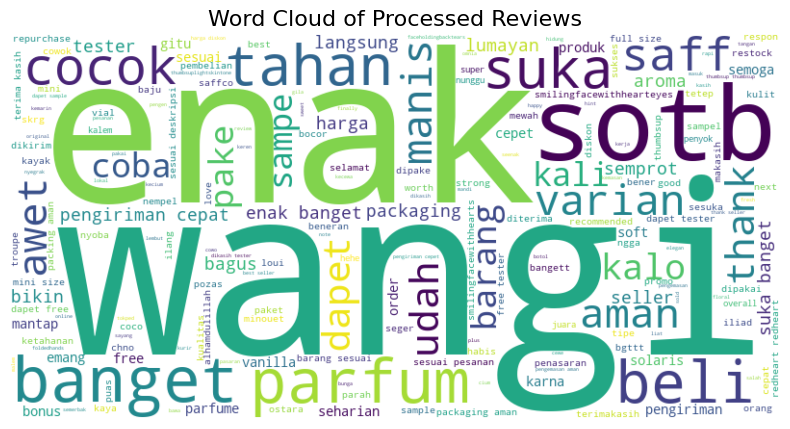

In [141]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all processed reviews into a single string
text = " ".join(review for review in data['processed_review'].dropna())

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Processed Reviews", fontsize=16)
plt.show()

In [142]:
import pandas as pd

# Load the uploaded file to check its structure
file_path = 'saff.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe to understand its structure
data.head(), data.columns

(                                             content  rating  \
 0  sudah sering beli disini. kualitas oke dan har...       5   
 1  Barang original dan tidak ada kekurangan sama ...       5   
 2  Sejak pertama kali saya mencoba Saff & Co. Ext...       5   
 3  Rasanya enak, berkualitas,wangi banget dan ban...       5   
 4  Wangi nya bikin nyaman enak di cium dan lama h...       5   
 
                                     processed_review  
 0  beli kualitas harga terjangkau produk tahan re...  
 1                         barang original kekurangan  
 2  kali mencoba saff extrait parfum saff benarben...  
 3  enak berkualitas wangi banget bikin nagih beli...  
 4           wangi bikin nyaman enak cium enak banget  ,
 Index(['content', 'rating', 'processed_review'], dtype='object'))

In [44]:
saff[["rating","bintang5"]]

,rating,bintang5
0,5.0,5254


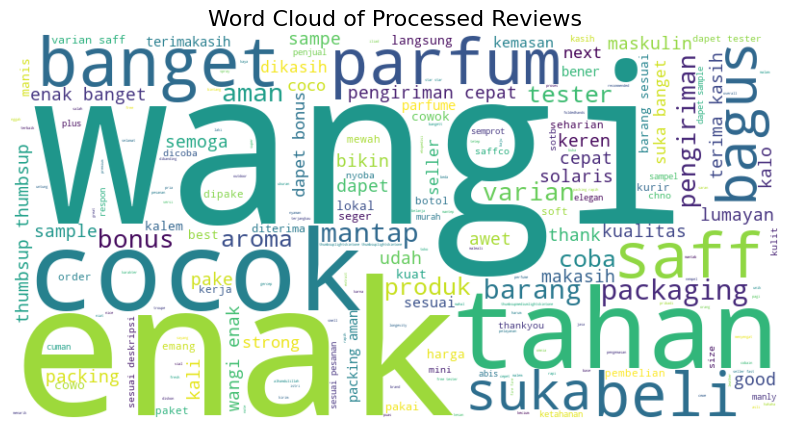

In [143]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all processed reviews into a single string
text = " ".join(review for review in data['processed_review'].dropna())

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Processed Reviews", fontsize=16)
plt.show()

In [63]:
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [64]:
data2 = pd.read_csv("merge_clean.csv")
data2['processed_review'] = data2['processed_review'].dropna()

data2['processed_review'] = data2['processed_review'].astype(str)

In [65]:
cvec = CountVectorizer(ngram_range=(1,2), min_df=.005, max_df=.9)
cvec.fit(data2['processed_review'])

CountVectorizer(max_df=0.9, min_df=0.005, ngram_range=(1, 2))

In [75]:
len(cvec.vocabulary_)

752

In [76]:
cvec_counts = cvec.transform(data2['processed_review'])
print('sparse matrix shape:', cvec_counts.shape)
print('nonzero count:', cvec_counts.nnz)
print('sparsity: %.2f%%' % (100.0 * cvec_counts.nnz / (cvec_counts.shape[0] * cvec_counts.shape[1])))

sparse matrix shape: (4142, 752)
nonzero count: 64108
sparsity: 2.06%


In [93]:
transformer = TfidfTransformer()

transformed_weights = transformer.fit_transform(cvec_counts)
transformed_weights = transformed_weights.toarray()
transformed_weights

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [94]:
vocab = cvec.get_feature_names_out()

model = pd.DataFrame(transformed_weights, columns=vocab)

model['Keyword'] = model.idxmax(axis=1)
model['Max'] = model.drop(columns=['Keyword']).max(axis=1)

model['Sum'] = model.drop(columns=['Keyword', 'Max']).sum(axis=1)

model.head(10)


,abis,ac,acara,ada,ada wangi,ada yg,admin,agak,agak kurang,aja,...,yang saya,yang suka,yg,yg ini,yg lain,yg suka,you,Keyword,Max,Sum
0,0.0,0.0,0.0,0.093991,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.076536,0.0,0.0,0.0,0.0,gw,0.308952,6.123470
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,terima,0.308371,5.183218
2,0.0,0.0,0.0,0.120161,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,jam,0.295589,5.341378
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,rasa,0.415410,4.991125
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,produk,0.409323,3.952108
5,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,mau beli,0.394884,3.479775
6,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,cocok di,0.400633,3.325876
7,0.0,0.0,0.0,0.183444,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.074688,0.0,0.0,0.0,0.0,di,0.393734,5.245010
8,0.0,0.0,0.0,0.125098,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,kurir,0.432410,4.682538
9,0.0,0.0,0.0,0.091206,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.074268,0.0,0.0,0.0,0.0,cuman,0.457878,5.702982


In [95]:
model = pd.merge(data2, model, left_index=True, right_index=True)

In [96]:
model.head(10)

,content,rating,processed_review,abis,ac,acara,ada,ada wangi,ada yg,admin,...,yang saya,yang suka,yg,yg ini,yg lain,yg suka,you,Keyword,Max,Sum
0,review jujur: ga begitu suka parfum yg baunya ...,4,review jujur ga begitu suka parfum yg manis tp...,0.0,0.0,0.0,0.093991,0.0,0.0,0.0,...,0.0,0.0,0.076536,0.0,0.0,0.0,0.0,gw,0.308952,6.123470
1,"seller nya responsive dan ramah, packaging nya...",4,seller responsive dan ramah packaging bagus da...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,terima,0.308371,5.183218
2,"Sekali lagi, packaging keren. Untuk 1x semprot...",4,sekali lagi packaging keren untuk x semprot lu...,0.0,0.0,0.0,0.120161,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,jam,0.295589,5.341378
3,aku sebenarnya ga begitu suka baunya. pas pert...,4,aku ga begitu suka pas pertama kali itu pink p...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,rasa,0.415410,4.991125
4,"Packing baik, produk masih baru dan tersegel d...",4,packing baik produk masih baru dan segel dan k...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,produk,0.409323,3.952108
5,"Bagus produknya, sekarang mau beli lagi yang k...",4,bagus sekarang mau beli lagi yang ke dua suka ...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,mau beli,0.394884,3.479775
6,Wanginya ternyata kurang cocok di aku. Tapi se...,4,nyata kurang cocok di aku tapi cara general wa...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,cocok di,0.400633,3.325876
7,suka wangi middle dan base notes-nya sprayer m...,3,suka wangi middle dan base sprayer rata ok tut...,0.0,0.0,0.0,0.183444,0.0,0.0,0.0,...,0.0,0.0,0.074688,0.0,0.0,0.0,0.0,di,0.393734,5.245010
8,"Untuk parfumnya sesuai dengan ekspetasi, kemas...",4,untuk sesuai dengan ekspetasi kemas unik karna...,0.0,0.0,0.0,0.125098,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,kurir,0.432410,4.682538
9,"Wangi dan packaging oke, sesuai dengan starter...",4,wangi dan packaging oke sesuai dengan starter ...,0.0,0.0,0.0,0.091206,0.0,0.0,0.0,...,0.0,0.0,0.074268,0.0,0.0,0.0,0.0,cuman,0.457878,5.702982


In [97]:
occ = np.asarray(cvec_counts.sum(axis=0)).ravel().tolist()
counts_df = pd.DataFrame({'Term': cvec.get_feature_names_out(), 'Occurrences': occ})
counts_df.sort_values(by='Occurrences', ascending=False).head(30)

,Term,Occurrences
152,dan,1702
747,yg,1155
727,wangi,1091
46,banget,1072
208,enak,1029
282,ini,1002
181,di,942
629,suka,866
369,lama,835
647,tapi,835


In [98]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree, metrics

In [99]:
model_p = model

In [100]:
model_p['Rating_3'] = [1 if x == 3 else 0 for x in model_p['rating']]
model_p['Rating_12'] = [1 if x == 1 or x == 2 else 0 for x in model_p['rating']]
model_p['Rating_45'] = [1 if x == 4 or x == 5 else 0 for x in model_p['rating']]

In [101]:
model_p

,content,rating,processed_review,abis,ac,acara,ada,ada wangi,ada yg,admin,...,yg ini,yg lain,yg suka,you,Keyword,Max,Sum,Rating_3,Rating_12,Rating_45
0,review jujur: ga begitu suka parfum yg baunya ...,4,review jujur ga begitu suka parfum yg manis tp...,0.000000,0.0,0.0,0.093991,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,gw,0.308952,6.123470,0,0,1
1,"seller nya responsive dan ramah, packaging nya...",4,seller responsive dan ramah packaging bagus da...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,terima,0.308371,5.183218,0,0,1
2,"Sekali lagi, packaging keren. Untuk 1x semprot...",4,sekali lagi packaging keren untuk x semprot lu...,0.000000,0.0,0.0,0.120161,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,jam,0.295589,5.341378,0,0,1
3,aku sebenarnya ga begitu suka baunya. pas pert...,4,aku ga begitu suka pas pertama kali itu pink p...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,rasa,0.415410,4.991125,0,0,1
4,"Packing baik, produk masih baru dan tersegel d...",4,packing baik produk masih baru dan segel dan k...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,produk,0.409323,3.952108,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4137,"pengiriman cepet seperti biasa, tp yg ini buka...",5,kirim cepet seperti biasa tp yg ini bukan saya...,0.222687,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.240647,0.0,0.0,0.0,sih,0.287864,5.028574,0,0,1
4138,konsisten wangi dan awet. Masih terjaga kualit...,5,konsisten wangi dan awet masih jaga dari tahub...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,dan awet,0.449713,2.865999,0,0,1
4139,wanginya biasa aja..tapi kemasannya yg oke men...,4,biasa ajatapi yg oke turut sayamaju terus prod...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,biasa,0.463750,2.416564,0,0,1
4140,Parfum Yang Varian SAFF cocok banget untuk pri...,5,parfum yang varian saff cocok banget untuk pri...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,smilingfacewithhearts,0.659072,4.163892,0,0,1


In [102]:
model_p.columns

Index(['content', 'rating', 'processed_review', 'abis', 'ac', 'acara', 'ada',
       'ada wangi', 'ada yg', 'admin',
       ...
       'yg ini', 'yg lain', 'yg suka', 'you', 'Keyword', 'Max', 'Sum',
       'Rating_3', 'Rating_12', 'Rating_45'],
      dtype='object', length=761)

In [103]:
ml_model3= model_p.drop(['content','rating','processed_review','Keyword',"Max","Sum"], axis=1)

In [104]:
ml_model3.columns

Index(['abis', 'ac', 'acara', 'ada', 'ada wangi', 'ada yg', 'admin', 'agak',
       'agak kurang', 'aja',
       ...
       'yang saya', 'yang suka', 'yg', 'yg ini', 'yg lain', 'yg suka', 'you',
       'Rating_3', 'Rating_12', 'Rating_45'],
      dtype='object', length=755)

In [105]:
X = ml_model3.drop(['Rating_12', 'Rating_3', 'Rating_45'], axis=1)
y = ml_model3[['Rating_12', 'Rating_3', 'Rating_45']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

### Logistic Regression

akurat

In [106]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [182]:
log_model = LogisticRegression(class_weight='balanced', solver = "lbfgs", C = 20)
log_model.fit(X_train, np.argmax(y_train.to_numpy(), axis = 1))

LogisticRegression(C=20, class_weight='balanced')

In [185]:
y_pred_train = log_model.predict(X_train)
print("Accuracy of Training Data:", accuracy_score(np.argmax(y_train.to_numpy(), axis = 1), y_pred_train))

Accuracy of Training Data: 0.9606760952052432


In [186]:
y_pred = log_model.predict(X_test)
print(classification_report(np.argmax(y_test.to_numpy(), axis = 1),y_pred))
print("Accuracy of Testing Data:",metrics.accuracy_score(np.argmax(y_test.to_numpy(), axis = 1), y_pred))

              precision    recall  f1-score   support

           0       0.22      0.33      0.27        51
           1       0.27      0.51      0.36        78
           2       0.96      0.88      0.92      1114

    accuracy                           0.83      1243
   macro avg       0.48      0.57      0.51      1243
weighted avg       0.88      0.83      0.85      1243

Accuracy of Testing Data: 0.831858407079646


### KNN

Memiliki akurasi yang menarik tapi saat test prediksi dengan text tidak akurat

In [199]:
from sklearn.neighbors import KNeighborsClassifier

In [201]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

KNeighborsClassifier()

In [200]:
y_pred_train = knn_model.predict(X_train)
print("Accuracy of Training Data:", accuracy_score(y_train, y_pred_train))

Accuracy of Training Data: 0.8989306657468092


In [202]:
y_pred = knn_model.predict(X_test)
print("Accuracy of Testing Data:", accuracy_score(y_test, y_pred))

Accuracy of Testing Data: 0.8897827835880934


### SVC
Cukup akurat

In [114]:
from sklearn.svm import SVC

In [ ]:
svc_model_linear = SVC(kernel='linear',class_weight='balanced')
svc_model_linear.fit(X_train, np.argmax(y_train.to_numpy(), axis = 1))

SVC(class_weight='balanced', kernel='linear')

In [ ]:
y_pred_train = svc_model_linear.predict(X_train)
print("Accuracy of Training Data:", accuracy_score(np.argmax(y_train.to_numpy(), axis = 1), y_pred_train))

Accuracy of Training Data: 0.9041048637461193


In [ ]:
y_pred = svc_model_linear.predict(X_test)
print("Accuracy of Testing Data:",metrics.accuracy_score(np.argmax(y_test.to_numpy(), axis = 1), y_pred))

Accuracy of Testing Data: 0.7996781979082864


### Multinomial Naive Bayes

sangat tidak akurat

In [118]:
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB

In [119]:
mnb_model = MultinomialNB()
mnb_model.fit(X_train, np.argmax(y_train.to_numpy(), axis = 1))

MultinomialNB()

In [120]:
y_pred_train = mnb_model.predict(X_train)
print("Accuracy of Training Data:", accuracy_score(np.argmax(y_train.to_numpy(), axis = 1), y_pred_train))

Accuracy of Training Data: 0.8968609865470852


In [121]:
y_pred = mnb_model.predict(X_test)
print("Accuracy of Testing Data:",metrics.accuracy_score(np.argmax(y_test.to_numpy(), axis = 1), y_pred))

Accuracy of Testing Data: 0.8962188254223652


### Random Forest Classifier
kurang akurat


In [233]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [234]:
rf_model = RandomForestClassifier(n_estimators=1000, class_weight='balanced', random_state=10)
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=1000,
                       random_state=10)

In [235]:
y_pred_train = rf_model.predict(X_train)
print("Accuracy of Testing Data:", accuracy_score(y_train.values.argmax(axis = 1), y_pred_train.argmax(axis = 1)))

Accuracy of Testing Data: 0.9851672990686443


In [236]:
y_pred = rf_model.predict(X_test)
print("Accuracy of Testing Data:", accuracy_score(y_test.values.argmax(axis = 1), y_pred.argmax(axis = 1)))

Accuracy of Testing Data: 0.8913917940466614


In [237]:
labels = list(y_train.columns)
feature_list = list(X_train.columns)

In [238]:
importances = list(rf_model.feature_importances_)
feature_importances = [(feature, importance) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
feature_importances = feature_importances[0:25]
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: kurang               Importance: 0.03104263967664786
Variable: suka                 Importance: 0.016747463133384814
Variable: kecewa               Importance: 0.014949327175360001
Variable: ga                   Importance: 0.01486639045220772
Variable: yg                   Importance: 0.013937579139625721
Variable: lama                 Importance: 0.01378115463927476
Variable: tidak                Importance: 0.013506570936944911
Variable: saya                 Importance: 0.013285350642583594
Variable: padahal              Importance: 0.013063724076384868
Variable: wangi                Importance: 0.012997833668507727
Variable: dan                  Importance: 0.012595542212318301
Variable: aja                  Importance: 0.011905525123570066
Variable: tahan                Importance: 0.01071432642992438
Variable: enak                 Importance: 0.010582125345579571
Variable: ini                  Importance: 0.010396054136383087
Variable: di                   Importance: 0

### XGBoost
sangta tidak akurat

In [239]:
from xgboost import XGBClassifier

In [240]:
# XGBoost
xgb_model = XGBClassifier(learning_rate =0.01, n_estimators=1000, max_depth=4, gamma=0, objective= 'multi:softmax', num_class=3, seed=27)
xgb_model.fit(X_train, np.argmax(y_train.to_numpy(), axis = 1))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...)

In [241]:
# Training Accuracy
y_pred_train = xgb_model.predict(X_train)
print("Accuracy of Training Data:", accuracy_score(np.argmax(y_train.to_numpy(), axis = 1), y_pred_train))

Accuracy of Training Data: 0.938254570541566


In [242]:
# Testing Accuracy
y_pred = xgb_model.predict(X_test)
print(classification_report(np.argmax(y_test.to_numpy(), axis = 1),y_pred))
print("Accuracy of Testing Data:",metrics.accuracy_score(np.argmax(y_test.to_numpy(), axis = 1), y_pred))

              precision    recall  f1-score   support

           0       0.50      0.06      0.11        51
           1       0.44      0.10      0.17        78
           2       0.90      0.99      0.95      1114

    accuracy                           0.90      1243
   macro avg       0.62      0.38      0.41      1243
weighted avg       0.86      0.90      0.86      1243

Accuracy of Testing Data: 0.8962188254223652


In [247]:
import re
import string
from nltk.tokenize import word_tokenize
import emoji
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.metrics import classification_report

class TextPreprocessor:
    def __init__(self):
        factory = StemmerFactory()
        self.lemmatizer = factory.create_stemmer()

    def replace_emojis(self, text):
        text = emoji.demojize(text)
        text = re.sub(r"[_-]", "", text)
        text = text.replace(":", " ")
        text = re.sub(r"\s+", " ", text).strip()
        return text

    def remove_repeated_characters(self, text):
        return re.sub(r'(.)\1{2,}', r'\1', text)

    def preprocess_review(self, text):
        text = text.lower()
        text = self.replace_emojis(text)
        text = re.sub(r"\.\.\.|…", " ", text)
        text = text.replace(",", " ")
        text = text.replace("’", "")
        text = text.translate(str.maketrans("", "", string.punctuation))
        text = re.sub(r"\d+", "", text)
        text = self.remove_repeated_characters(text)
        text = re.sub(r"\b\w*nya\b", "", text)
        tokens = word_tokenize(text)
        lemmatized_tokens = [self.lemmatizer.stem(token) for token in tokens]
        return ' '.join(lemmatized_tokens)


def predict_manual_input(model, preprocessor, vectorizer):
    review_input = input("Masukkan review untuk prediksi: ")

    processed_review = preprocessor.preprocess_review(review_input)

    vectorized_input = vectorizer.transform([processed_review])

    prediction = model.predict(vectorized_input)
    print(review_input)
    print(f"Prediksi untuk review tersebut adalah: {prediction[0]}")


preprocessor = TextPreprocessor()

predict_manual_input(xgb_model, preprocessor, cvec)


kecewa
Prediksi untuk review tersebut adalah: 1
